## 第二题

构建数据集类，建立数据集

读取图片所在文件夹路径下的全部文件，并将labels读取出来

In [1]:
import os

#文件处理
def Preprocess(folder_path):
    file_names = os.listdir(folder_path)
    labels = [] 
    paths = []
    for file_name in file_names: 
        if os.path.isdir(file_name):
            continue

        file_path = os.path.join(folder_path, file_name) 
        paths.append(file_path)

        label = file_name.split("_")[0]
        labels.append(label)

    return paths,labels

数据集类

In [2]:
import os
import torch

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor

from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_paths, labels = None,transform=None):
        self.data_paths = data_paths
        self.labels =labels
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
       #读取图片
        img_path = self.data_paths[idx]
        img = Image.open(img_path).convert('RGB')
        #获取标签
        
        if self.transform is not None:
            img = self.transform(img)
            
        if self.labels is not None:       
            label = self.labels[idx]

            return img, label
        else:
            return img

In [3]:
import torchvision.transforms as transforms
train_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),                                
    transforms.ToTensor(),
])

In [4]:

train_root="./all-dogs/"


data_paths_train, label_train = Preprocess(train_root)

# 创建自定义数据集实例
train_dataset = CustomDataset(data_paths_train, label_train,train_transform)

print(len(train_dataset))

# 创建数据加载器
batch_size=128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

print(train_loader)


20579


构建自编码模型

In [5]:
import torch
import torch.nn as nn
# 定义卷积自编码器模型
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # 编码器（卷积部分）
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # 解码器（反卷积部分）
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32,  kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64,  kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3,  kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
# 设置超参数
learning_rate = 0.001
num_epochs = 50
device='cuda'

In [7]:
import torch

class MSE(torch.nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        self.squared_difference = torch.nn.MSELoss(reduction='none')

    def forward(self, X, Y):
        return torch.mean(self.squared_difference(X, Y))


In [74]:
import time
# 构建网络
model = Autoencoder().to(device)
# 定义损失函数
loss_func = MSE()

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 训练过程中的损失函数列表
losses = []
# 每个epoch训练时间列表
epoch_times = []
# 训练模型
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()  # 记录每个epoch的开始时间
    for data, _ in train_loader:
        
        data=data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, data)
        loss.backward()
        optimizer.step()
        

    print('Epoch: {}, Loss: {:.6f}'.format(epoch+1,loss.item()))
    end_time = time.time()  # 记录每个epoch的结束时间
    # 计算每个epoch训练所花时间
    epoch_time = end_time - start_time 
    epoch_times.append(epoch_time)
    print('Epoch: {}, Time: {:.2f} seconds'.format(epoch+1, epoch_time))

Epoch: 1, Loss: 0.020713
Epoch: 1, Time: 64.98 seconds


In [60]:
# 保存模型
torch.save(model, './model/dog.pth')
torch.save(model.state_dict(), './model/dog_dict.pth')

In [59]:
model=torch.load('./model/dog.pth').to('cuda')

从已经加载好的数据中随机获取9个(为了下面的显示好看，用了10张图片)

In [60]:
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


batch = next(iter(train_loader))
random_indices = random.sample(range(batch[0].size(0)), min(10, batch[0].size(0)))
random_images = batch[0][random_indices]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


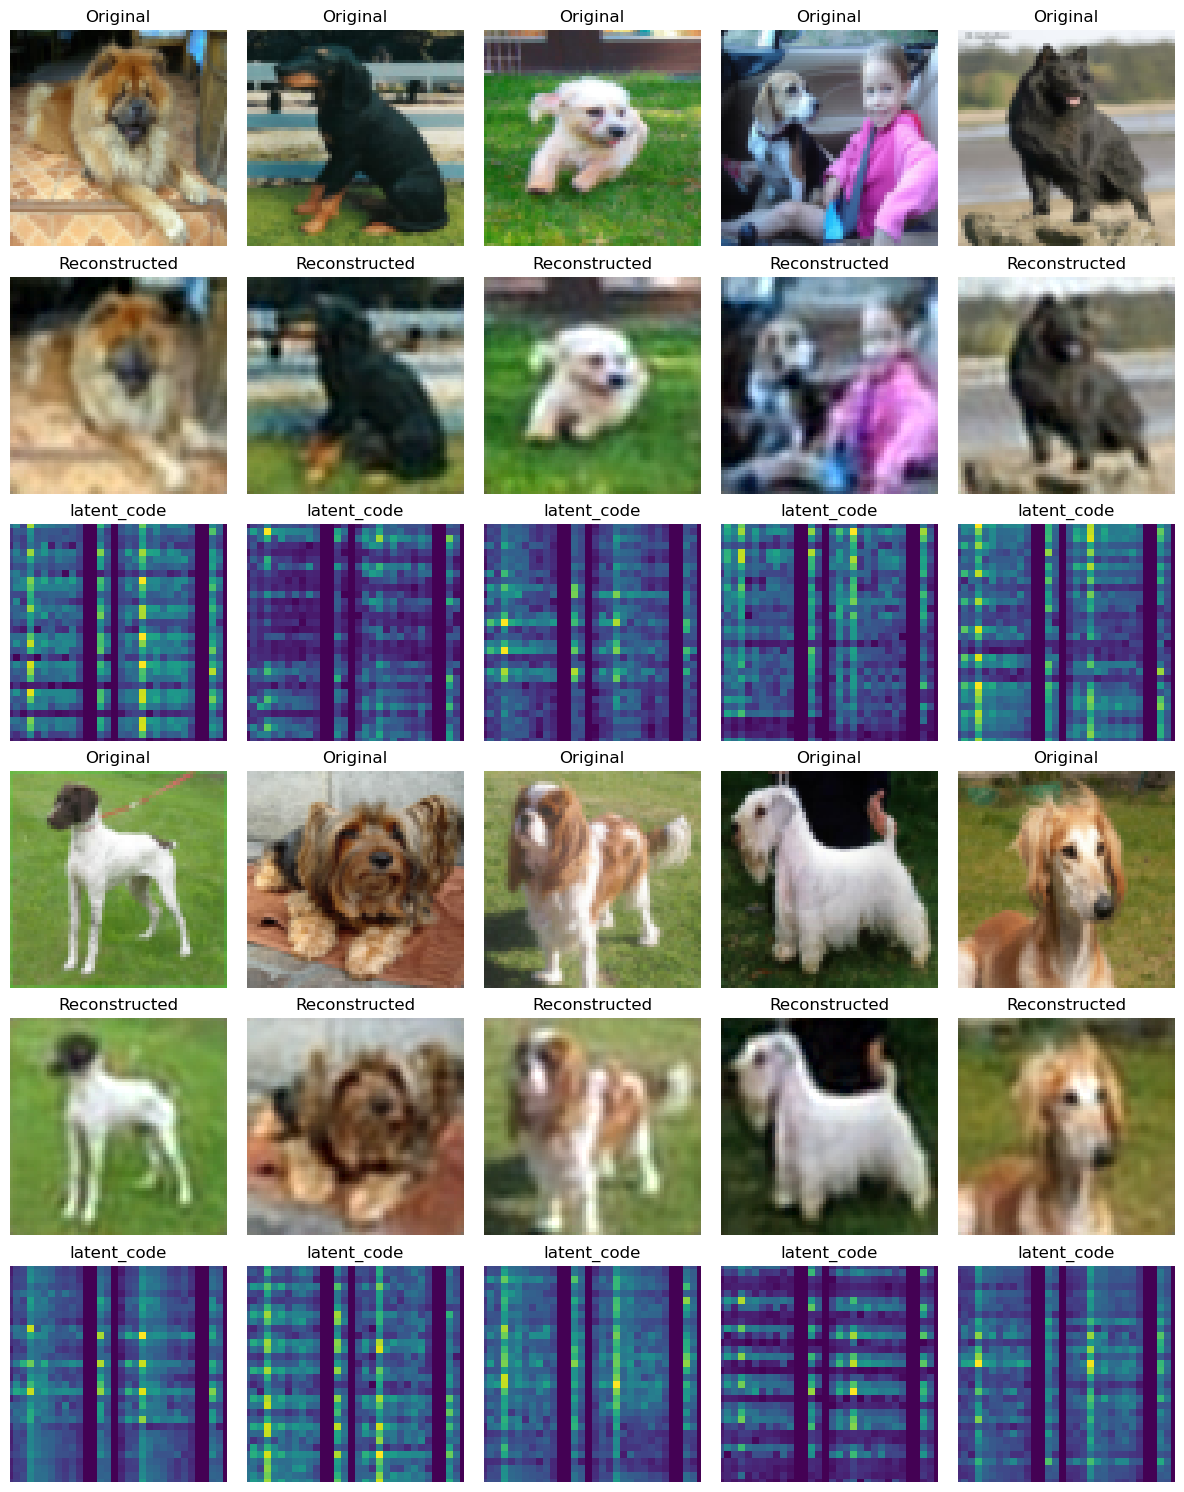

In [63]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(6, 5, figsize=(12, 15))  # 调整网格大小，使得每行放置5对图片

for i, image in enumerate(random_images):
    original_image = image.permute(1, 2, 0)  # 将图片的通道维度调整到最后
    reconstructed_image = model(image.unsqueeze(0).to(device)).squeeze().detach().cpu().permute(1, 2, 0)

    img = image.unsqueeze(0)
    img = img.to(device)
    latent_code_gpu = model.encoder(img)
    latent_code_cpu = latent_code_gpu.detach().cpu().numpy()  # 转移到 CPU 上，并转换为 numpy 数组
    mx = np.max(latent_code_cpu)
    mn = np.min(latent_code_cpu)
    latent_flat = ((latent_code_cpu - mn) * 255/(mx - mn)).flatten(order='F')
    latent_code_img = Image.fromarray(latent_flat[:1024].astype('uint8').reshape((32,32)),  mode='L')


    #设置行、列索引
    if i<5:
        row = i // 5  
        col = i % 5   
    else:
        row = (i // 5)+2 
        col = i % 5  
        
    axes[row, col].imshow(original_image)  # 原始图片
    axes[row, col].axis('off')
    axes[row+1, col].set_title('Reconstructed')  # 添加标题
    axes[row+2, col].imshow(latent_code_img)  # latent_code
    axes[row+2, col].set_xlim((0,31))
    axes[row+2, col].set_ylim((0,31))
    axes[row+2, col].axis('off')
    axes[row, col].set_title('Original')  # 添加标题
    axes[row+1, col].imshow(reconstructed_image)  # 重建图片
    axes[row+1, col].axis('off')
    axes[row+2, col].set_title('latent_code')  # 添加标题
    
plt.tight_layout()
plt.show()

可视化

In [96]:
model.to('cuda')
with torch.no_grad():
    for data,_ in train_loader:
        data=data.to('cuda')
        latent_codes=model.encoder(data)


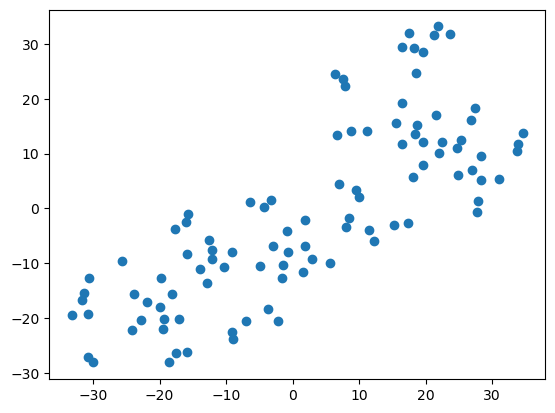

In [66]:
# 将latent_codes reshape为2维
latent_codes_reshaped = latent_codes.view(latent_codes.size(0), -1)

# 将降维后的数据应用于t-SNE进行可视化
tsne = TSNE(n_components=2, perplexity=5)
latent_codes_2d_tsne = tsne.fit_transform(latent_codes_reshaped.cpu().detach().numpy())

# 创建散点图
plt.scatter(latent_codes_2d_tsne[:, 0], latent_codes_2d_tsne[:, 1])

# 显示图形
plt.show()

In [27]:
# 可视化函数
def visualize_feature_maps(feature_maps):
    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(10, 5))
    for i, ax in enumerate(axs.flat):
        ax.imshow(feature_maps[i].detach().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

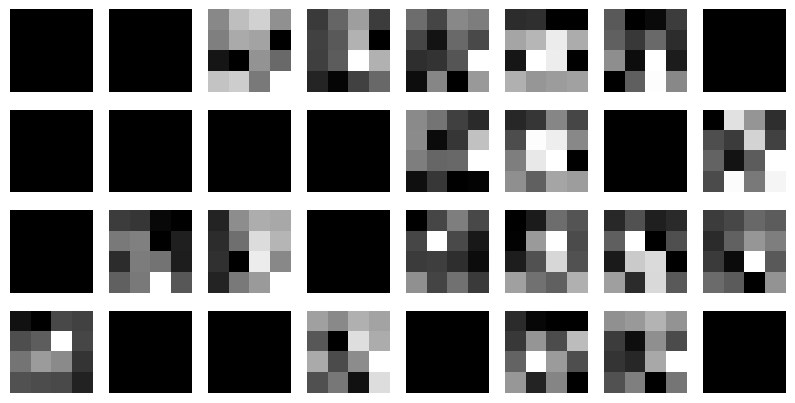

In [28]:
# 获取编码器的特征图
with torch.no_grad():
    feature_maps = latent_codes[1]  # 取最后一个卷积层的输出作为特征图
# 可视化特征图
visualize_feature_maps(feature_maps)

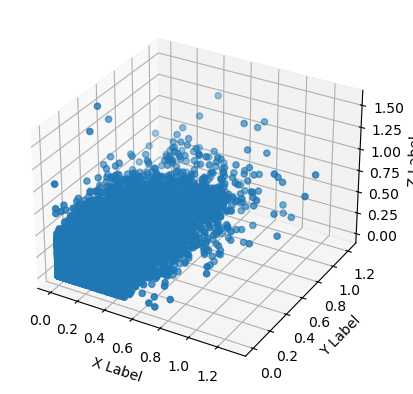

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

latent_codes=latent_codes.cpu().detach().numpy()
# 将latentcode转换为2维坐标系中的点
x = latent_codes[:, :, 0].flatten()
y = latent_codes[:, :, 1].flatten()
z = latent_codes[:, :, 2].flatten()

# 创建3D散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

# 设置坐标轴标签
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 显示图形
plt.show()

#### 任务3

先随机选取256张图片

In [64]:
import random

model.cpu()
batch = next(iter(train_loader))
random_indices = random.sample(range(batch[0].size(0)), min(256, batch[0].size(0)))
random_images = batch[0][random_indices]
latent_codes_list = []
for images in random_images:
    latent_codes=model.encoder(images)

    latent_code_cpu = latent_codes.detach().cpu().numpy()  # 转移到 CPU 上，并转换为 numpy 数组
    latent_code_cpu = latent_code_cpu.flatten(order='F')

    latent_codes_list.append(latent_code_cpu)
latent_codes_list = np.array(latent_codes_list)  #存放256个latent_code



In [65]:
print(latent_codes.shape)
print(latent_codes_list.shape)

torch.Size([16, 8, 8])
(128, 1024)


In [66]:
#  计算latent  code的统计特性，均值和协方差
mean = np.mean(latent_codes_list, axis=0)
cov_matrix = np.cov(latent_codes_list, rowvar=False)  

# 构造高斯分布
gaussian_dist = np.random.multivariate_normal(mean, cov_matrix)
print(gaussian_dist.shape)


(1024,)


可视化高斯

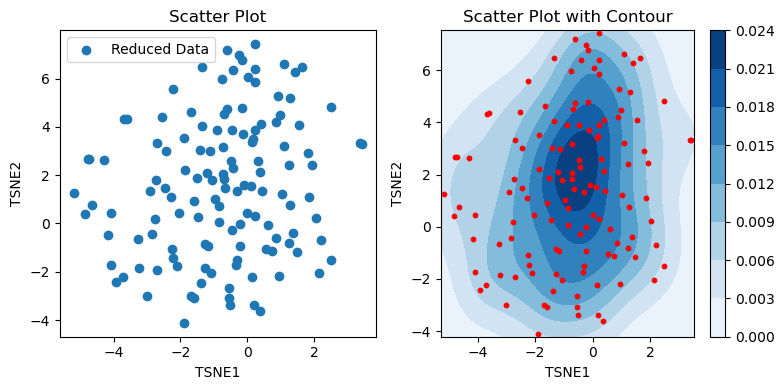

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde

# 使用 t-SNE 进行数据降维
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(latent_codes_list)

# 绘制降维后的散点图和等高线图
plt.figure(figsize=(8, 4))

# 绘制散点图
plt.subplot(121)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label='Reduced Data')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Scatter Plot')
plt.legend()

# 绘制等高线图
plt.subplot(122)
x = reduced_data[:, 0]
y = reduced_data[:, 1]

# 创建等高线所需的网格
x_min, x_max = x.min()-0.1, x.max()+0.1
y_min, y_max = y.min()-0.1, y.max()+0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# 计算对应网格点上的数值
kde = gaussian_kde(reduced_data.T)
zz = kde(np.vstack([xx.ravel(), yy.ravel()]))
zz = zz.reshape(xx.shape)

# 绘制等高线图
plt.contourf(xx, yy, zz, cmap='Blues')
plt.colorbar()
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Scatter Plot with Contour')
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='r', s=10)

plt.tight_layout()
plt.show()

在高斯分布上随机采9个点，返回decoder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


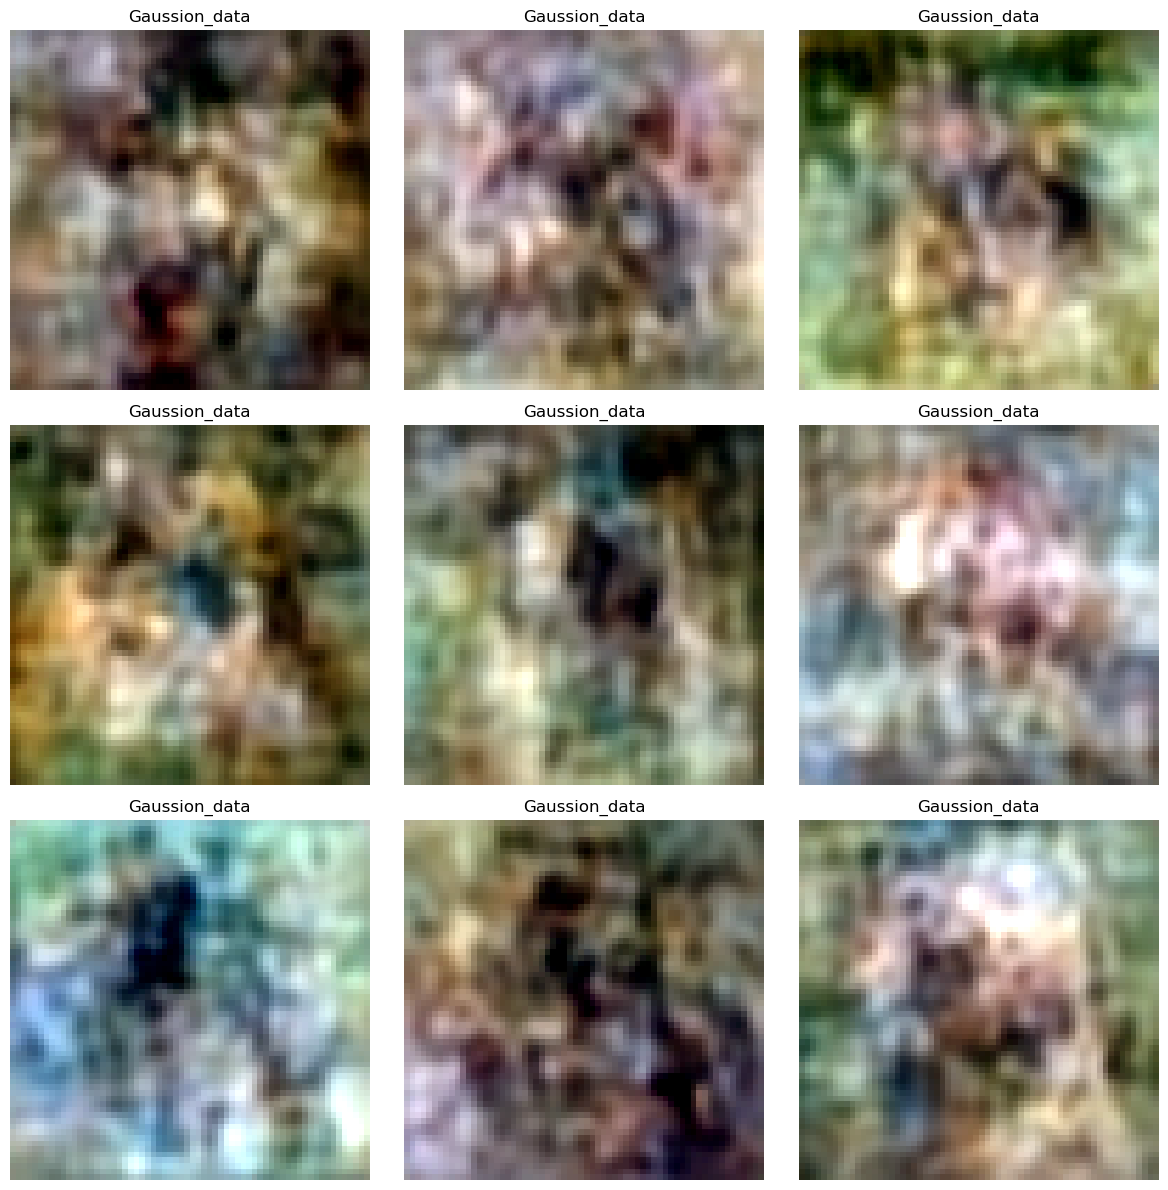

In [80]:
import  numpy  as  np
#  随机抽取9个点
sampled_points  =  np.random.multivariate_normal(mean,  cov_matrix,  9)

print(len(sampled_points))

fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 调整网格大小，使得每行放置3对图片
for i,data in enumerate(sampled_points):
    new_latent_code = data[:1024].reshape((16,8,8),order='F')
    new_latent_code = torch.from_numpy(new_latent_code)
    new_latent_code = new_latent_code.to(torch.float32)
    new_reconstructed_image = model.decoder(new_latent_code.unsqueeze(0).to(device)).squeeze().detach().cpu().permute(1, 2, 0)
    
    row = i // 3  
    col = i % 3 
    axes[row, col].imshow(new_reconstructed_image)  # 原始图片
    axes[row, col].axis('off')
    axes[row, col].set_title('Gaussion_data')  # 添加标题
plt.tight_layout()
plt.show()

任务4

In [70]:
model.to('cuda')

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


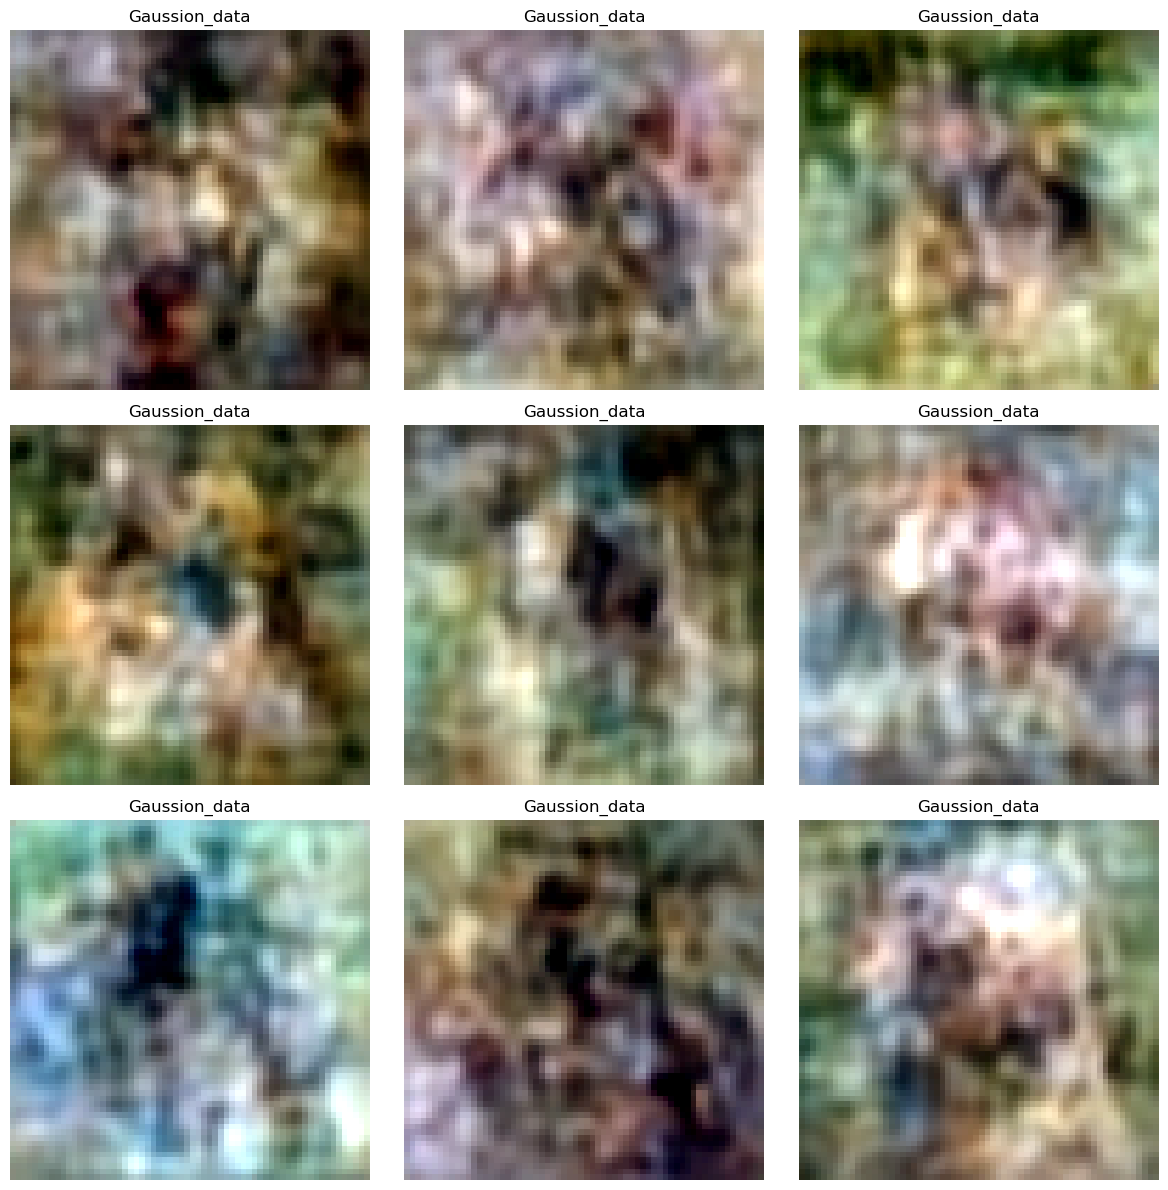

In [81]:
import  numpy  as  np

#  在这些点上叠加随机的高斯噪声扰动
noise  =  np.random.randn(9,  1024)
sampled_points  =  np.concatenate((sampled_points,  noise),  axis=1)

print(len(sampled_points))

fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 调整网格大小，使得每行放置3对图片
for i,data in enumerate(sampled_points):
    new_latent_code = data[:1024].reshape((16,8,8),order='F')
    new_latent_code = torch.from_numpy(new_latent_code)
    new_latent_code = new_latent_code.to(torch.float32)
    new_reconstructed_image = model.decoder(new_latent_code.unsqueeze(0).to(device)).squeeze().detach().cpu().permute(1, 2, 0)
    
    row = i // 3  
    col = i % 3 
    axes[row, col].imshow(new_reconstructed_image)  # 原始图片
    axes[row, col].axis('off')
    axes[row, col].set_title('Gaussion_data')  # 添加标题
plt.tight_layout()
plt.show()

任务5

添加噪声的类

In [5]:
import torch


class MSE(torch.nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        self.squared_difference = torch.nn.MSELoss(reduction='none')

    def forward(self, X, Y):
        return torch.mean(self.squared_difference(X, Y))


In [6]:
import torch.nn as nn
import numpy as np
import os
import torch


class add_noise(nn.Module):
    def __init__(self, std):
        super(add_noise, self).__init__()
        self.std = std  # 标准差

    # 生成高斯噪声
    def gaussian_noise_layer(self, input_layer, std):
        noise = torch.normal(mean=0.0, std=std, size=np.shape(input_layer))
        noise = noise.to(input_layer.get_device())
        
        return input_layer + noise

    # 进行归一化
    def normalize(self, x):
        pwr = torch.mean(x ** 2)
        out = x / torch.sqrt(pwr)
        return out

    def forward(self, input):
        latent_code = self.normalize(input)
        noisy_code = self.gaussian_noise_layer(latent_code, self.std)
        return noisy_code

In [7]:
import torch
import torch.nn as nn
# 定义卷积自编码器模型
class Autoencoder_noise(nn.Module):
    def __init__(self,noise_std):
        super(Autoencoder_noise, self).__init__()
        self.add_noise=add_noise(noise_std)
        # 编码器（卷积部分）
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # 解码器（反卷积部分）
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32,  kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64,  kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3,  kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        add_noise_encoded=self.add_noise(encoded)
        decoded = self.decoder(add_noise_encoded)
        return decoded

In [68]:
import time
import math
# 构建网络
device='cuda'
variance=0.15
std=math.sqrt(variance)

model_noise = Autoencoder_noise(std).to(device)


In [36]:
model_noise=torch.load('./model/dog_noise0.05.pth').to('cuda')

In [69]:
# 定义损失函数
loss_func = MSE()

# 定义优化器
optimizer = torch.optim.Adam(model_noise.parameters())



In [70]:
num_epochs=50

In [71]:
import time
from tqdm.auto import tqdm
# 训练过程中的损失函数列表
losses = []
# 每个epoch训练时间列表
epoch_times = []
# 训练模型
for epoch in range(num_epochs):
    model_noise.train()
    start_time = time.time()  # 记录每个epoch的开始时间
    for data, _ in tqdm(train_loader):
        data=data.to(device)
        optimizer.zero_grad()
        
        output = model_noise(data)
        loss = loss_func(output, data)
        loss.backward()
        optimizer.step()
        

    print('Epoch: {}, Loss: {:.6f}'.format(epoch+1,loss.item()))
    end_time = time.time()  # 记录每个epoch的结束时间
    # 计算每个epoch训练所花时间
    epoch_time = end_time - start_time 
    epoch_times.append(epoch_time)
    print('Epoch: {}, Time: {:.2f} seconds'.format(epoch+1, epoch_time))

100%|██████████| 161/161 [01:05<00:00,  2.46it/s]


Epoch: 1, Loss: 0.013408
Epoch: 1, Time: 65.34 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 2, Loss: 0.011642
Epoch: 2, Time: 64.44 seconds


100%|██████████| 161/161 [01:04<00:00,  2.49it/s]


Epoch: 3, Loss: 0.010518
Epoch: 3, Time: 64.59 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 4, Loss: 0.011367
Epoch: 4, Time: 64.45 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 5, Loss: 0.009063
Epoch: 5, Time: 64.52 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 6, Loss: 0.008898
Epoch: 6, Time: 64.47 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 7, Loss: 0.009082
Epoch: 7, Time: 64.44 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 8, Loss: 0.009071
Epoch: 8, Time: 64.45 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 9, Loss: 0.008220
Epoch: 9, Time: 64.52 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 10, Loss: 0.007510
Epoch: 10, Time: 64.49 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 11, Loss: 0.007273
Epoch: 11, Time: 64.41 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 12, Loss: 0.007198
Epoch: 12, Time: 64.41 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 13, Loss: 0.007786
Epoch: 13, Time: 64.31 seconds


100%|██████████| 161/161 [01:04<00:00,  2.49it/s]


Epoch: 14, Loss: 0.006882
Epoch: 14, Time: 64.59 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 15, Loss: 0.006431
Epoch: 15, Time: 64.41 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 16, Loss: 0.006564
Epoch: 16, Time: 64.43 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 17, Loss: 0.006581
Epoch: 17, Time: 64.30 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 18, Loss: 0.006810
Epoch: 18, Time: 64.47 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 19, Loss: 0.005918
Epoch: 19, Time: 64.47 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 20, Loss: 0.007627
Epoch: 20, Time: 64.42 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 21, Loss: 0.006000
Epoch: 21, Time: 64.41 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 22, Loss: 0.006084
Epoch: 22, Time: 64.41 seconds


100%|██████████| 161/161 [01:04<00:00,  2.48it/s]


Epoch: 23, Loss: 0.006287
Epoch: 23, Time: 64.96 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 24, Loss: 0.006548
Epoch: 24, Time: 64.40 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 25, Loss: 0.006188
Epoch: 25, Time: 64.41 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 26, Loss: 0.005910
Epoch: 26, Time: 64.37 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 27, Loss: 0.005723
Epoch: 27, Time: 64.25 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 28, Loss: 0.005814
Epoch: 28, Time: 64.33 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 29, Loss: 0.006126
Epoch: 29, Time: 64.36 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 30, Loss: 0.005800
Epoch: 30, Time: 64.28 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 31, Loss: 0.005562
Epoch: 31, Time: 64.39 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 32, Loss: 0.005863
Epoch: 32, Time: 64.20 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 33, Loss: 0.006066
Epoch: 33, Time: 64.22 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 34, Loss: 0.006256
Epoch: 34, Time: 64.34 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 35, Loss: 0.005727
Epoch: 35, Time: 64.28 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 36, Loss: 0.005522
Epoch: 36, Time: 64.25 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 37, Loss: 0.006120
Epoch: 37, Time: 64.25 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 38, Loss: 0.006011
Epoch: 38, Time: 64.33 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 39, Loss: 0.005465
Epoch: 39, Time: 64.32 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 40, Loss: 0.005226
Epoch: 40, Time: 64.31 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 41, Loss: 0.006104
Epoch: 41, Time: 64.27 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 42, Loss: 0.006083
Epoch: 42, Time: 64.41 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 43, Loss: 0.005836
Epoch: 43, Time: 64.17 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 44, Loss: 0.005861
Epoch: 44, Time: 64.29 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 45, Loss: 0.005960
Epoch: 45, Time: 64.19 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 46, Loss: 0.005579
Epoch: 46, Time: 64.25 seconds


100%|██████████| 161/161 [01:04<00:00,  2.50it/s]


Epoch: 47, Loss: 0.005323
Epoch: 47, Time: 64.30 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 48, Loss: 0.006115
Epoch: 48, Time: 64.20 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


Epoch: 49, Loss: 0.005250
Epoch: 49, Time: 64.26 seconds


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]

Epoch: 50, Loss: 0.005632
Epoch: 50, Time: 64.24 seconds


In [72]:
# 保存模型
torch.save(model_noise, './model/dog_noise0.15.pth')
torch.save(model_noise.state_dict(), './model/dog_dict_noise0.15.pth')

In [73]:
model1=torch.load('./model/dog_noise0.05.pth').to('cuda')
model2=torch.load('./model/dog_noise0.1.pth').to('cuda')
model3=torch.load('./model/dog_noise0.15.pth').to('cuda')

In [74]:
import torch


class MSE(torch.nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        self.squared_difference = torch.nn.MSELoss(reduction='none')

    def forward(self, X, Y):
        return torch.mean(self.squared_difference(X, Y))


In [75]:
device='cuda'
loss_func=MSE()
psnr1_list=[]
psnr2_list=[]
psnr3_list=[]

with torch.no_grad():
    for data, _ in train_loader:
        data=data.to(device)

        output1 = model1(data)
        loss1=loss_func(output1,data)
        
        output2 = model2(data)
        loss2=loss_func(output2,data)
      
        output3 = model3(data)
        loss3=loss_func(output3,data)


        psnr1 = 20 * np.log10(np.max(output1.cpu().detach().numpy()) / np.sqrt(loss1.cpu().detach().numpy()))  # 计算PSNR

        psnr2 = 20 * np.log10(np.max(output1.cpu().detach().numpy()) / np.sqrt(loss2.cpu().detach().numpy()))

        psnr3 = 20 * np.log10(np.max(output2.cpu().detach().numpy()) / np.sqrt(loss3.cpu().detach().numpy()))

        psnr1_list.append(psnr1)
        psnr2_list.append(psnr2)
        psnr3_list.append(psnr3)
            



In [45]:
def  calculate_mean(numbers):
    total  =  sum(numbers)
    mean  =  total  /  len(numbers)
    return  mean

In [77]:
psnr1_mean=calculate_mean(psnr1_list)
psnr2_mean=calculate_mean(psnr2_list)
psnr3_mean=calculate_mean(psnr3_list)
print('方差为0.05:',psnr1_mean,'dB')
print('方差为0.1:',psnr2_mean,'dB')
print('方差为0.15:',psnr3_mean,'dB')

方差为0.05: 23.440586306293557 dB
方差为0.1: 22.93103674183721 dB
方差为0.15: 22.244557371791107 dB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


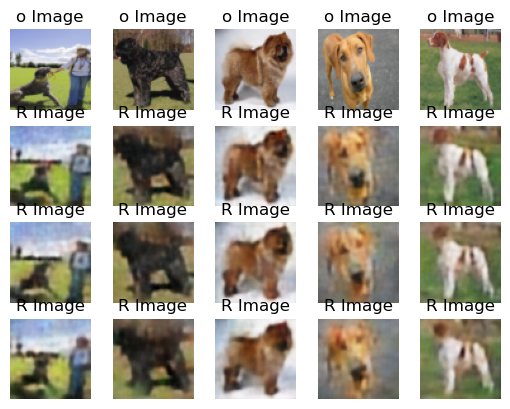

In [83]:
import random
import matplotlib.pyplot as plt
# 随机选择五个样本进行可视化
sample_indices = random.sample(range(len(output1)), 5) # 随机选择5个索引
original_image1=data[sample_indices]
# 重构图像
reconstructed_sample1 = output1[sample_indices]
reconstructed_sample2 = output2[sample_indices]
reconstructed_sample3 = output3[sample_indices]

# reconstructed_sample1=reconstructed_sample1.numpy()

# reconstructed_sample2=reconstructed_sample2.numpy()

# reconstructed_sample3=reconstructed_sample3.numpy()

for i in range(5):    
    plt.subplot(4, 5, i + 1)
    plt.imshow(np.transpose(original_image1.cpu()[i], (1, 2, 0)))
    plt.axis('off')
    plt.title('o Image')

for i in range(5):    
    plt.subplot(4, 5, 5+i + 1)
    plt.imshow(np.transpose(reconstructed_sample1.cpu()[i], (1, 2, 0)))
    plt.axis('off')
    plt.title('R Image')
for i in range(5):    
    plt.subplot(4, 5, 10+i + 1)
    plt.imshow(np.transpose(reconstructed_sample2.cpu()[i], (1, 2, 0)))
    plt.axis('off')
    plt.title('R Image')
for i in range(5):    
    plt.subplot(4, 5, 15+i + 1)
    plt.imshow(np.transpose(reconstructed_sample3.cpu()[i], (1, 2, 0)))
    plt.axis('off')
    plt.title('R Image')


In [38]:
psnr_avg = (psnr1 + psnr2 + psnr3) / 3
print(psnr_avg)

22.372008164723713


探索生成能力，先随机生成一个16*8*8的张量输入来替代latent_code

In [15]:
model=torch.load('./model/dog.pth').to('cuda')

随机生成一个16*8*8的张量

In [43]:
with torch.no_grad():
    for data, _ in train_loader:
        data=data.to('cuda')
        lat=model.encoder(data)

In [50]:
print(lat[0])


print(calculate_mean(lat[0]))

tensor([[[1.1438, 1.8467, 0.2136,  ..., 0.5515, 0.8051, 0.6350],
         [1.5437, 1.6567, 0.8157,  ..., 1.4972, 1.1917, 0.7289],
         [1.7451, 1.3792, 0.9864,  ..., 1.4238, 1.7064, 0.9476],
         ...,
         [1.7734, 1.4123, 1.3557,  ..., 0.5653, 0.5929, 1.4712],
         [1.6327, 1.0783, 0.9348,  ..., 0.7024, 0.8102, 0.9405],
         [1.2904, 0.0000, 1.0956,  ..., 1.1675, 1.0175, 1.2592]],

        [[2.2024, 2.6053, 1.2086,  ..., 1.1419, 0.9032, 1.0083],
         [1.4708, 3.1251, 1.5729,  ..., 0.9103, 1.0763, 0.8299],
         [1.7081, 2.0951, 1.7140,  ..., 1.3863, 1.3701, 1.0925],
         ...,
         [1.1273, 2.1453, 1.5459,  ..., 1.2977, 1.1268, 1.7048],
         [2.4152, 2.7801, 1.2673,  ..., 0.8130, 1.6632, 1.8239],
         [1.0974, 2.9411, 2.0861,  ..., 1.6917, 1.5334, 1.6130]],

        [[1.5584, 2.9414, 0.3412,  ..., 0.6749, 0.3893, 0.5426],
         [1.5931, 2.6336, 0.8370,  ..., 0.2924, 0.6347, 0.2774],
         [1.6206, 2.1221, 0.8952,  ..., 0.9115, 0.3578, 0.

In [51]:
import numpy as np
import torch
image_array = np.random.randint(0, 5, size=(16, 8, 8))
image_tensor = torch.from_numpy(image_array).to('cuda')
image_tensor = image_tensor.float()  # 将图像张量转换为torch.cuda.FloatTensor类型

In [52]:
re_image=model.decoder(image_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '')

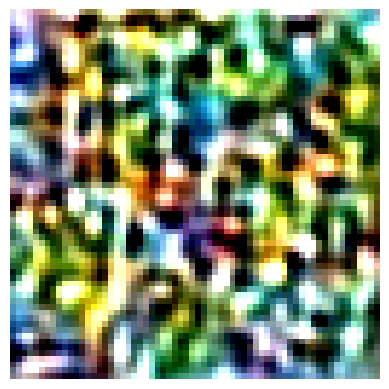

In [53]:
import matplotlib.pyplot as plt
plt.subplot(1, 1, 1)
plt.imshow(np.transpose(re_image.cpu().detach().numpy(), (1, 2, 0)))
plt.axis('off')
plt.title('')